---
Principal Component Analysis (PCA)
---

In [1]:
import os 

_path=os.path.abspath('.')
expo_path=_path+os.sep+'data'+os.sep+'pca'+os.sep+'factorExposure'
factor_path=_path+os.sep+'data'+os.sep+'pca'+os.sep+'keyFactor'
try:
    os.mkdir(expo_path) 
except: 
    print("Dir has already been created!")
finally:
    try: 
        os.mkdir(factor_path)
    except: 
        print("Dir has already been created!")


Dir has already been created!
Dir has already been created!


__Main__

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import os 
from numpy.linalg import eig
%matplotlib inline

class factorAnalysis:
    def __init__(self, 
                 compo_path, #an excel file  to store components
                 ix_path, #index: a .csv file to store index hist stock price
                 freq,  #portfolio rebalance freqency 
                 rollingWindow):
        self.compo_path=compo_path   
        self.ix_path=ix_path 
        self.freq=freq 
        self.rollingWindow=rollingWindow
        
        
    def fetchData(self):
        self.compo=pd.read_excel(self.compo_path)
        self.compo=self.compo[self.compo.columns[1:]].copy()  
        self.compo.sort_values(by=['Date'], inplace=True)
        self.compo.fillna(method='ffill', inplace=True)
        self.compo.fillna(method='bfill', inplace=True)
        self.compo.set_index('Date', inplace=True)
        
        
        self.r=self.compo/self.compo.shift(1)-1
        self.r.fillna(0, inplace=True)
        
        
        #bechmark
        self.ix=pd.read_csv(self.ix_path)
        self.ix['Date']=pd.to_datetime(self.ix['Date'])
         
        
    def pca(self, start, AnalysisDate):
        X=self.r[(self.r.index>=start) & (self.r.index<=AnalysisDate)].copy()  
        X=X-X.mean()
        A=np.dot(X.T.values,X.values)/len(X)
        vals, vecs=eig(A)
        indices=vals.argsort()[::-1]
        vals, vecs=vals[indices], vecs[:, indices]
        return X, vals, vecs 
    
    
    def pacHist(self): 
        datelist=self.r.index.tolist() 
        for i, _day in enumerate(datelist[self.rollingWindow-1::self.freq]):
            start=datelist[self.freq*i].strftime('%Y-%m-%d')
            AnalysisDate=_day.strftime('%Y-%m-%d')
            X, vals, vecs=self.pca(start, AnalysisDate)
            cumval=vals.cumsum()/vals.sum()
            indices=np.where(cumval>=0.5)
            k=indices[0][0]+1 
             
            
            expo=pd.DataFrame(index=self.r.columns.tolist())
            facPerf=pd.DataFrame(index=X.index)
            for i in range(k):
                expo['factor{}'.format(i+1)]=vecs[:, i]
                facPerf['factor{}'.format(i+1)]=np.dot(vecs[:,i].T, X.T.values)
                facPerf['factor{}'.format(i+1)]= (1+0.01*facPerf['factor{}'.format(i+1)]).cumprod()
            expo.to_excel("./data/pca/factorExposure/factorExposure_{}.xlsx".format(AnalysisDate))
            facPerf.to_excel("./data/pca/keyFactor/keyFactor_{}.xlsx".format(AnalysisDate))
            
    def pcaOneday(self, i): 
        file=sorted(os.listdir('./data/pca/keyFactor'))[i]
        print(file)
        df=pd.read_excel('./data/pca/keyFactor'+os.sep+file)
        datelist=df.Date.tolist()
        start=datelist[0].strftime('%Y-%m-%d')
        AnalysisDate=datelist[-1].strftime('%Y-%m-%d')
        return start, AnalysisDate
         
    def figExpo(self, AnalysisDate):
        df=pd.read_excel("./data/pca/factorExposure/factorExposure_{}.xlsx".format(AnalysisDate))
        df.set_index(df.columns[0], inplace=True)
        df.index.name='ticker'
        fig, axes=plt.subplots(nrows=2, ncols=1, figsize=(15,16))
        df[['factor1', 'factor2']].plot(ax=axes[0], title='Factor Exposure')
        df.plot(ax=axes[1], title='Factor Exposure')
        for i in [0,1]: 
            axes[i].spines['top'].set_visible(False) 
            axes[i].spines['right'].set_visible(False)
            axes[i].legend(frameon=False); 
        plt.tight_layout()
        plt.savefig('./output/fig/figexpo')
       
         
           
        
    def figFac(self, start,  AnalysisDate):
        df=pd.read_excel("./data/pca/keyFactor/keyFactor_{}.xlsx".format(AnalysisDate))
        df.set_index(df.columns[0], inplace=True)
        df.index=pd.to_datetime(df.index).strftime('%Y-%m-%d')
        df.index.name='datetime'
        
        ix=self.ix[(self.ix['Date']>=start) & (self.ix['Date']<=AnalysisDate)].copy()
        ix.set_index('Date', inplace=True)
         
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,16))
        df.plot(ax=axes[0], title='Key-Factor Performance')
        ix['Price'].plot(ax=axes[1], title='Index Performance') 
        for i in [0,1]: 
            axes[i].spines['top'].set_visible(False) 
            axes[i].spines['right'].set_visible(False)
            axes[i].legend(frameon=False);
        plt.tight_layout()
        plt.savefig('./output/fig/figfac')
        

keyFactor_2007-12-04.xlsx


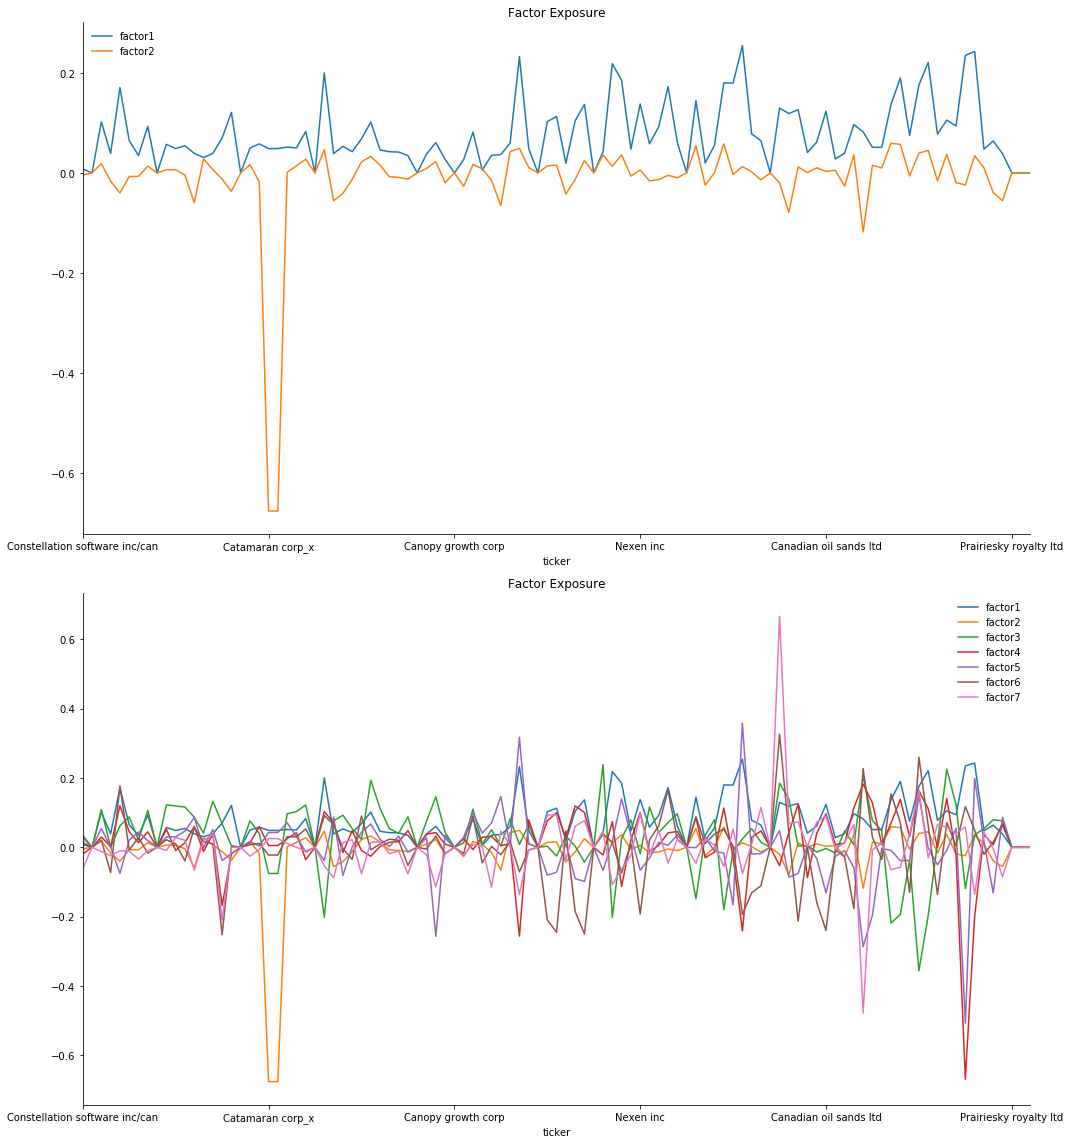

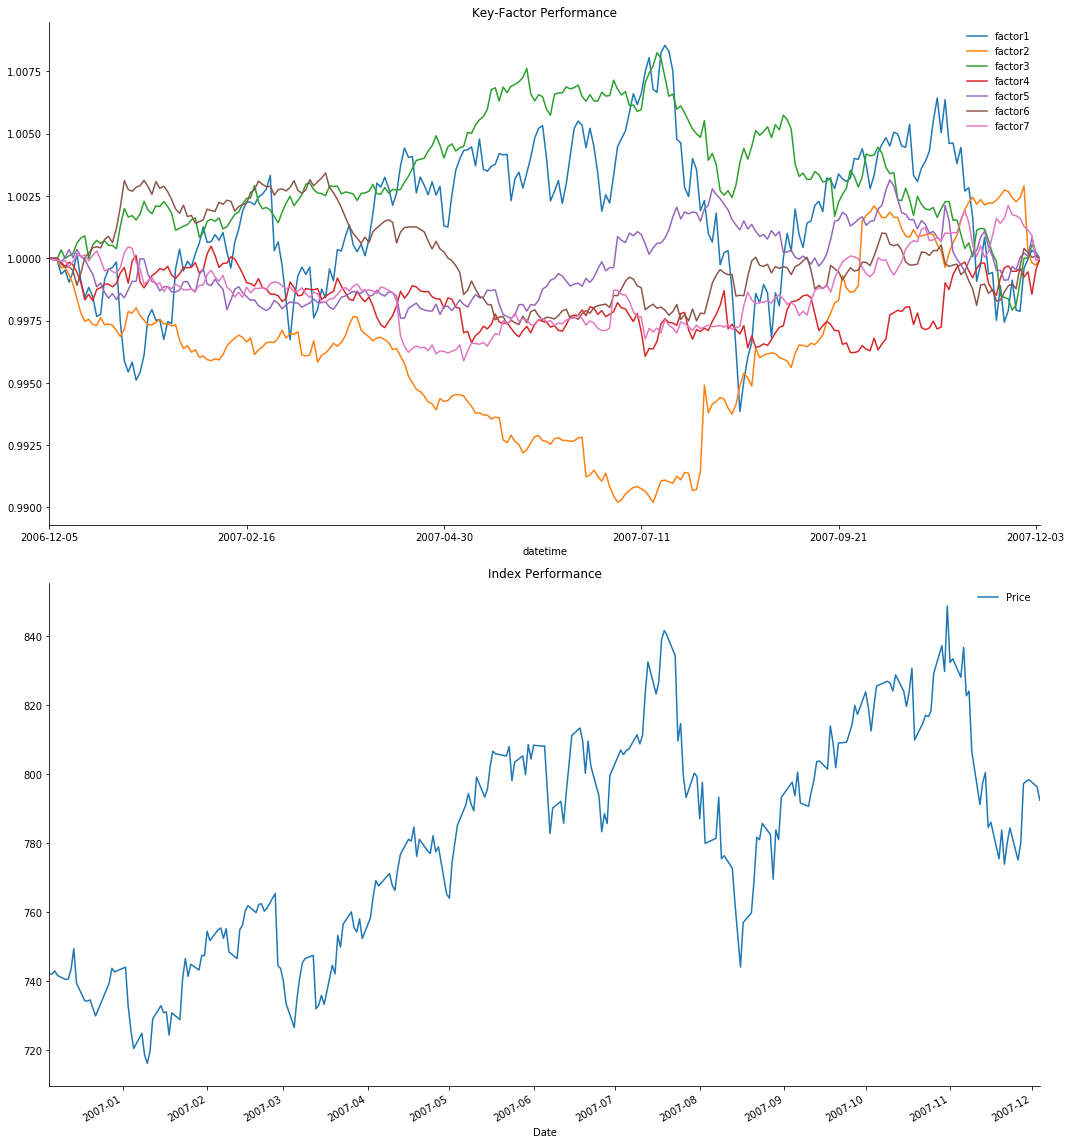

In [3]:
if __name__=='__main__':
    index_path="./data/pca/pca_tsx60.xlsx"
    bch_path='./data/yahoo/TSX60.csv'
    freq=1 #one day
    rollingWindow=252 #one year
     
    ins=factorAnalysis(index_path, bch_path, freq, rollingWindow)
    ins.fetchData()
     
    
    ins.pacHist()
      
    
    start, AnalysisDate=ins.pcaOneday(0)
    ins.figExpo(AnalysisDate)
    ins.figFac(start, AnalysisDate)
      
 

---